In [339]:
import os
import sys
import torch
import numpy as np
import scipy
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from scipy.io import loadmat, savemat
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score 

 

# %load_ext pycodestyle_magic


warnings.filterwarnings("ignore")

tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)


def matricize(data):
    return torch.Tensor(np.reshape(data, (-1, np.prod(data.shape[1:])), order="F"))


def rmse(y_true, y_pred):
    """Compute Root Mean Square Percentage Error between two arrays."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))


def qsquared(y_true, y_pred):
    """Compute the Q^2 Error between two arrays."""
    return 1 - ((torch.norm(y_true - y_pred) ** 2) / (torch.norm(y_true) ** 2))


def cov(A, B):
    """Computes the mode 1 (mode 0 in python) contraction of 2 matrices."""
    assert A.shape[0] == B.shape[0], "A and B need to have the same shape on axis 0"
    dimension_A = A.shape[1:]
    dimension_B = B.shape[1:]
    dimensions = list(dimension_A) + list(dimension_B)
    rmode_A = len(dimension_A)
    dim = A.shape[0]
    C = tl.zeros(dimensions)
    indices = []
    for mode in dimensions:
        indices.append(range(mode))
    for idx in product(*indices):
        idx_A, idx_B = list(idx[:rmode_A]), list(idx[rmode_A:])
        C[idx] = np.sum(
            [A[tuple([i] + idx_A)] * B[tuple([i] + idx_B)] for i in range(dim)]
        )
    return C


class HOPLS:
    def __init__(self, R, Ln, Km=None, metric=None, epsilon=0):
        """
        Parameters:
            R: int, The number of latent vectors.
            Ln: list, the ranks for the decomposition of X: [L2, ..., LN].
            Km: list, the ranks for the decomposition of Y: [K2, ..., KM].
            epsilon: Float, default: 10e-7, The implicit secondary criterion of the
                algorithm. The algorithm will stop if we have not reached R but the
                residuals have a norm smaller than epsilon.
        """
        self.R = R
        self.Ln = Ln
        self.N = len(self.Ln)
        self.Km = Km
        if Km is not None:
            self.M = len(self.Km)
        else:
            self.M = 2
        self.epsilon = epsilon
        if metric is None:
            self.metric = qsquared
        else:
            self.metric = metric
        self.model = None
        self.mY = None

    def _fit_2d(self, X, Y):
        """
        Compute the HOPLS for X and Y wrt the parameters R, Ln and Km for the special case mode_Y = 2.
        Parameters:
            X: tensorly Tensor, The target tensor of shape [i1, ... iN], N = 2.
            Y: tensorly Tensor, The target tensor of shape [j1, ... jM], M >= 3.
        Returns:
            G: Tensor, The core Tensor of the HOPLS for X, of shape (R, L2, ..., LN).
            P: List, The N-1 loadings of X.
            D: Tensor, The core Tensor of the HOPLS for Y, of shape (R, K2, ..., KN).
            Q: List, The N-1 loadings of Y.
            ts: Tensor, The latent vectors of the HOPLS, of shape (i1, R).
        """

        # Initialization
        Er, Fr = X, Y
        P, T, W, Q = [], [], [], []
        D = tl.zeros((self.R, self.R))
        G = []

        # Beginning of the algorithm
        # Gr, _ = tucker(Er, ranks=[1] + self.Ln)
        for r in range(self.R):
            print (torch.norm(Er) )
            if torch.norm(Er) > self.epsilon and torch.norm(Fr) > self.epsilon:
                # computing the covariance
                Cr = mode_dot(Er, Fr.t(), 0)

                # HOOI tucker decomposition of C
                Gr_C, latents = tucker(Cr, rank=[1] + self.Ln)

                # Getting P and Q loadings
                qr = latents[0]
                qr /= torch.norm(qr)
                # Pr = latents[1:]
                Pr = [a / torch.norm(a) for a in latents[1:]]
                P.append(Pr)
                tr = multi_mode_dot(Er, Pr, list(range(1, len(Pr) + 1)), transpose=True)

                GrC_pi = torch.pinverse(matricize(Gr_C))
                tr = torch.mm(matricize(tr), GrC_pi)
                tr /= torch.norm(tr)

                # recomposition of the core tensor of Y
                ur = torch.mm(Fr, qr)
                dr = torch.mm(ur.t(), tr)

                D[r, r] = dr
                Pkron = kronecker([Pr[self.N - n - 1] for n in range(self.N)])

                Q.append(qr)
                T.append(tr)
                Gd = tl.tucker_to_tensor([Er, [tr] + Pr], transpose_factors=True)
                Gd_pi = torch.pinverse(matricize(Gd))
                W.append(torch.mm(Pkron, Gd_pi))

                Er = Er - tl.tucker_to_tensor([Gd, [tr] + Pr])
                Fr = Fr - dr * torch.mm(tr, qr.t())
                
                fig, ax = plt.subplots(2,sharex=True, sharey=True)
                im0 = ax[0].imshow(Er[0,:,:]);
                im1 = ax[1].imshow(X[0,:,:]);
                fig.suptitle('Number of latent vectors: '+str(r) )
                
                
#                 plt.imshow(Er[0,:,:])
#                 plt.imshow(X[0,:,:])
#                 plt.title(str(r))
                plt.show()
            else:
                
                break
        
#         print ('Q',Y[0::5][0], len(T))
        Q = torch.cat(Q, dim=1)
        T = torch.cat(T, dim=1)
        # P = torch.cat(P, dim=1)
        W = torch.cat(W, dim=1)
#         print ('TT',T.shape,T)

        for lv1,lv2,lv3 in [[0,1,2],[5,6,7]]:
        
            fig = plt.figure(figsize = (15, 10))
            ax = plt.axes(projection ="3d")

            # Creating plot
            ax.scatter3D(T[0::5,lv1], T[0::5,lv2], T[0::5,lv3], c =np.array(Y[0::5])[:,0])
            ax.set_xlabel('Latent Variable ' + str(lv1), fontweight ='bold')
            ax.set_ylabel('Latent Variable ' + str(lv2), fontweight ='bold')
            ax.set_zlabel('Latent Variable ' + str(lv3), fontweight ='bold')
            plt.title("Each point denotes image")

            # show plot
            plt.show()
        self.model = (P, Q, D, T, W)
        return self

    def fit(self, X, Y):
        """
        Compute the HOPLS for X and Y wrt the parameters R, Ln and Km.
        Parameters:
            X: tensorly Tensor, The target tensor of shape [i1, ... iN], N >= 3.
            Y: tensorly Tensor, The target tensor of shape [j1, ... jM], M >= 3.
        Returns:
            G: Tensor, The core Tensor of the HOPLS for X, of shape (R, L2, ..., LN).
            P: List, The N-1 loadings of X.
            D: Tensor, The core Tensor of the HOPLS for Y, of shape (R, K2, ..., KN).
            Q: List, The N-1 loadings of Y.
            ts: Tensor, The latent vectors of the HOPLS, of shape (i1, R).
        """
        # check parameters
        X_mode = len(X.shape)
        Y_mode = len(Y.shape)
        assert Y_mode >= 2, "Y need to be mode 2 minimum."
        assert X_mode >= 3, "X need to be mode 3 minimum."
        assert (
            len(self.Ln) == X_mode - 1
        ), f"The list of ranks for the decomposition of X (Ln) need to be equal to the mode of X -1: {X_mode-1}."
        if Y_mode == 2:
            return self._fit_2d(X, Y)
        assert (
            len(self.Km) == Y_mode - 1
        ), f"The list of ranks for the decomposition of Y (Km) need to be equal to the mode of Y -1: {Y_mode-1}."

        # Initialization
        Er, Fr = X, Y
        In = X.shape
        T, G, P, Q, D, W = [], [], [], [], [], []

        # Beginning of the algorithm
        for r in range(self.R):
            
            if torch.norm(Er) > self.epsilon and torch.norm(Fr) > self.epsilon:
                Cr = torch.Tensor(np.tensordot(Er, Fr, (0, 0)))
                # HOOI tucker decomposition of C
                _, latents = tucker(Cr, rank=self.Ln + self.Km)

                # Getting P and Q loadings
                Pr = latents[: len(Er.shape) - 1]
                Qr = latents[len(Er.shape) - 1 :]

                # computing product of Er by latents of X
                tr = multi_mode_dot(Er, Pr, list(range(1, len(Pr))), transpose=True)

                # Getting t as the first leading left singular vector of the product
                tr = torch.svd(matricize(tr))[0][:, 0]
                tr = tr[..., np.newaxis]
                
                
                
                # recomposition of the core tensors
                Gr = tl.tucker_to_tensor([Er, [tr] + Pr], transpose_factors=True)
                Dr = tl.tucker_to_tensor(Fr, [tr] + Qr, transpose_factors=True)
                Pkron = kronecker([Pr[self.N - n - 1] for n in range(self.N)])
                Gr_pi = torch.pinverse(matricize(Gr))
                W.append(torch.mm(Pkron, Gr_pi))

                # Gathering of
                P.append(Pr)
                Q.append(Qr)
                G.append(Gr)
                D.append(Dr)
                T.append(tr)

                # Deflation
                Er = Er - tl.tucker_to_tensor(Gr, [tr] + Pr)
                Fr = Fr - tl.tucker_to_tensor(Dr, [tr] + Qr)
                
            else:
                break
        
        print (G,' fdsf')
        T = torch.cat(T, dim=1)
        W = torch.cat(W, dim=1)
        self.model = (P, Q, D, T, W)
        return self

    def predict(self, X, Y):
        """Compute the HOPLS for X and Y wrt the parameters R, Ln and Km.
        Parameters:
            X: tensorly Tensor, The tensor we wish to do a prediction from.
            Of shape [i1, ... iN], N >= 3.
            Y: tensorly Tensor, used only for the shape of the prediction.
        Returns:
            Y_pred: tensorly Tensor, The predicted Y from the model.
        """
        _, Q, D, _, W = self.model
        best_q2 = -np.inf
        if len(Y.shape) > 2:
            Q_star = []
            for r in range(self.R):
                Qkron = kronecker([Q[r][self.M - m - 1] for m in range(self.M)])
                Q_star.append(torch.mm(matricize(D[r][np.newaxis, ...]), Qkron.t()))
            Q_star = torch.cat(Q_star)
        q2s = []
        for r in range(1, self.R + 1):
            if len(Y.shape) == 2:
                Q_star = torch.mm(D[:r, :r], Q[:, :r].t())
            inter = torch.mm(W[:, :r], Q_star[:r])
            Y_pred = np.reshape(torch.mm(matricize(X), inter), Y.shape, order="F")
            Q2 = qsquared(Y, Y_pred)
            q2s.append(Q2)
            if Q2 > best_q2:
                best_q2 = Q2
                best_r = r
                best_Y_pred = Y_pred
#         print (best_Y_pred)
        return best_Y_pred, best_r, q2s

    def score(self, X, Y):
        self.fit(X, Y)
        Y_pred = self.predict(X, Y)
        return self.metric(Y.reshape(Y.shape[0], -1), Y_pred.reshape(Y.shape[0], -1))

In [342]:
# %pycodestyle_off

In [343]:
X_train_bad =[np.load('C:\\Users\\safiu\\JointDataset\\Train\\bad\\' + str(f), mmap_mode='r') for f in os.listdir('C:\\Users\\safiu\\JointDataset\\Train\\bad\\')[:2000]]
X_train_good =[np.load('C:\\Users\\safiu\\JointDataset\\Train\\good\\' + str(f), mmap_mode='r') for f in os.listdir('C:\\Users\\safiu\\JointDataset\\Train\\good\\')[:2000]]
data_y = [[1,0]]*len(X_train_good) + [[0,-1]]*len(X_train_bad)
data_X= np.concatenate((X_train_good,X_train_bad))

## Тензор из датасета

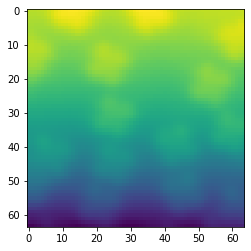

In [344]:
plt.imshow(data_X[0,:,:])

## Модель

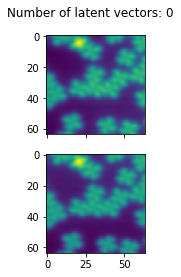

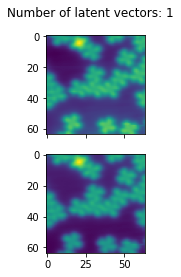

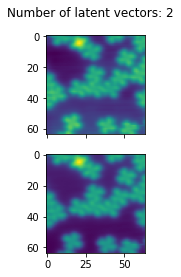

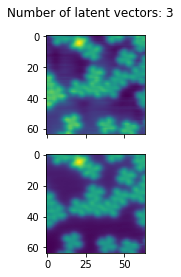

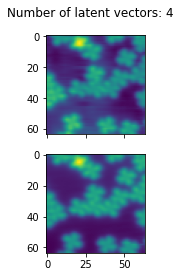

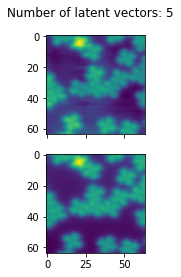

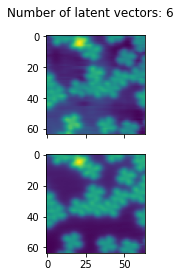

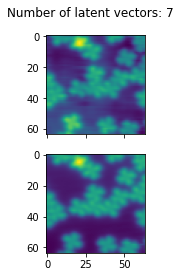

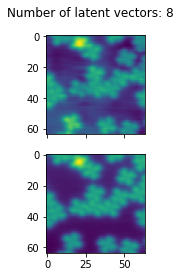

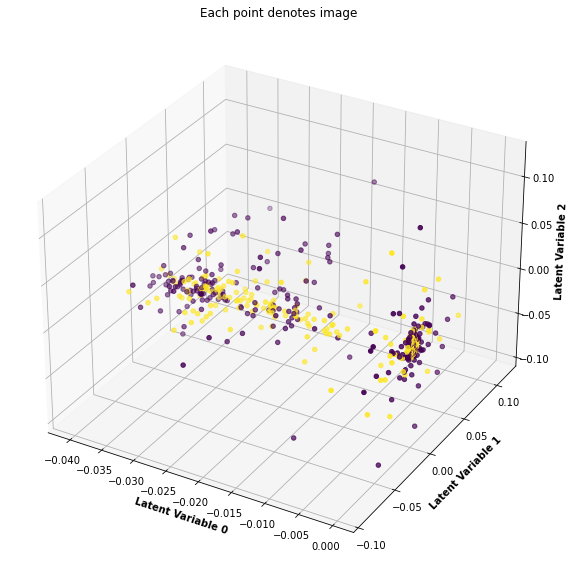

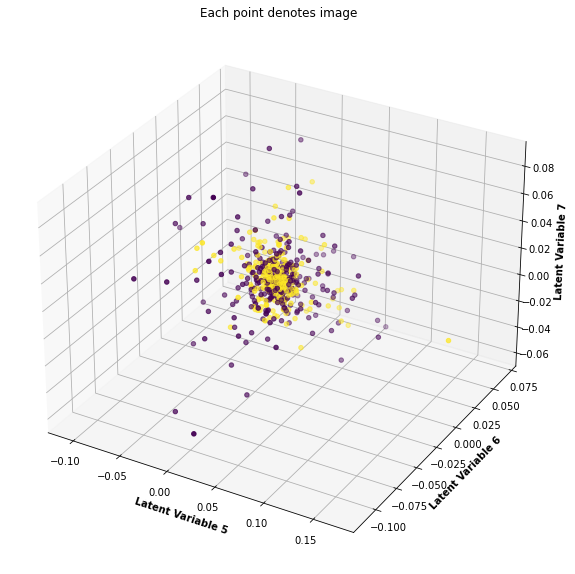

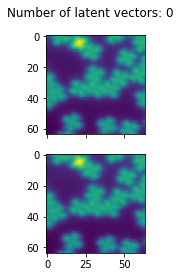

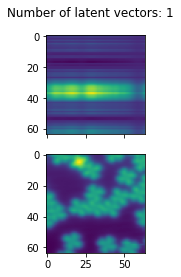

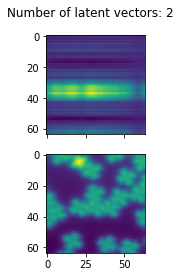

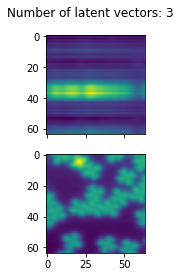

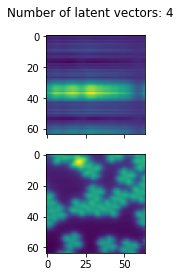

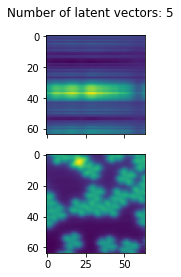

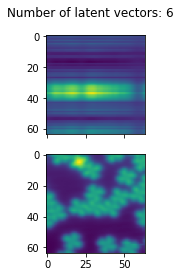

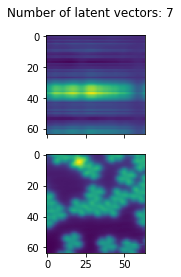

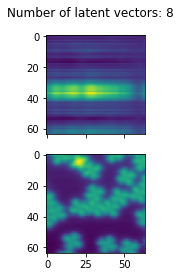

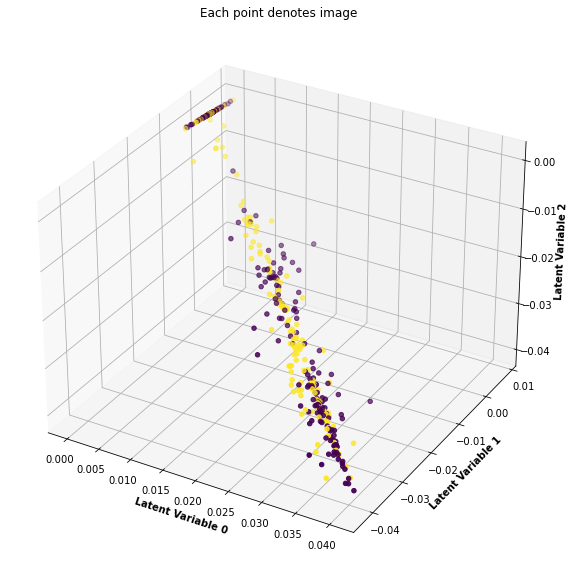

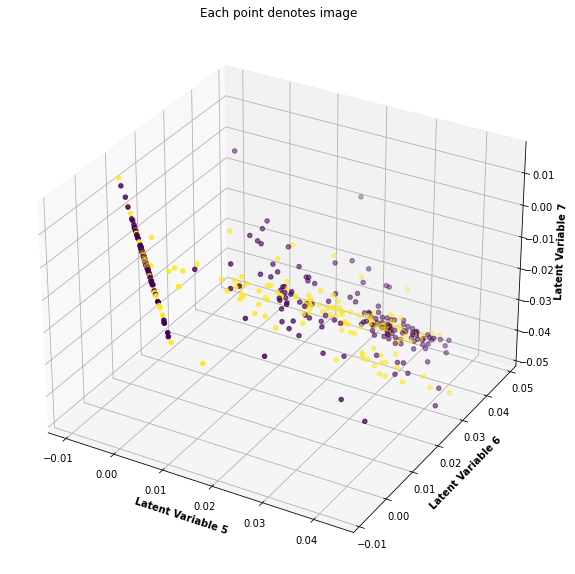

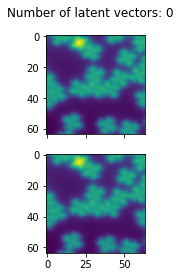

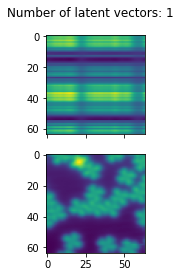

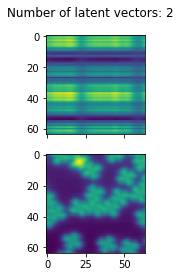

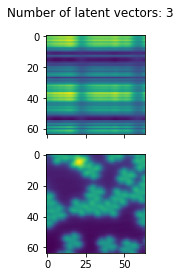

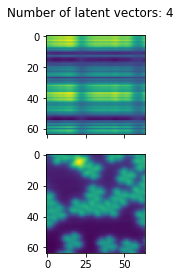

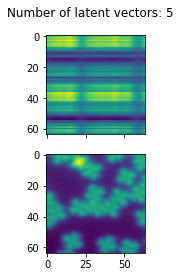

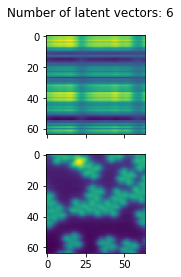

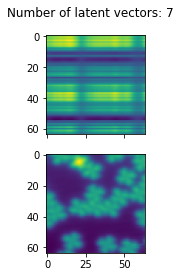

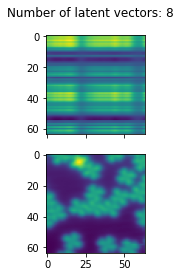

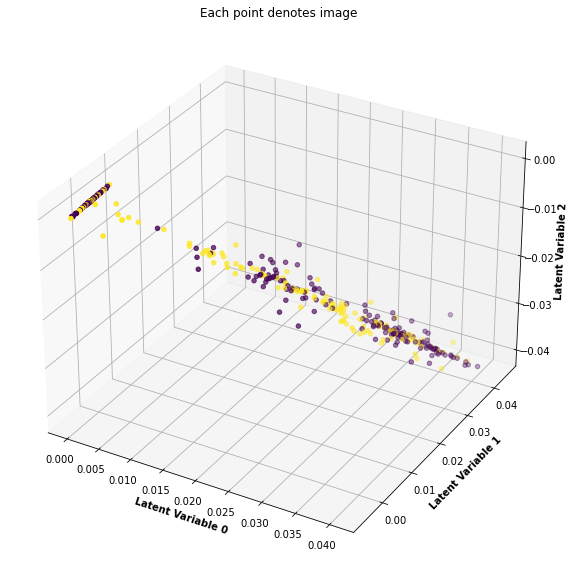

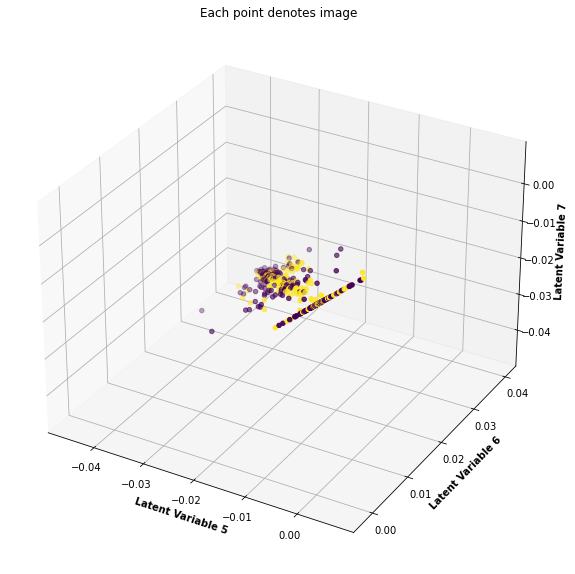

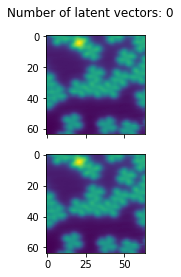

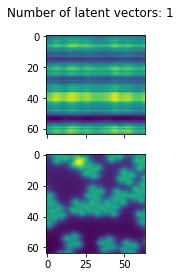

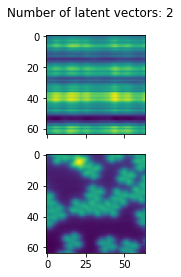

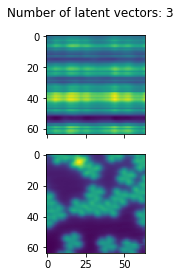

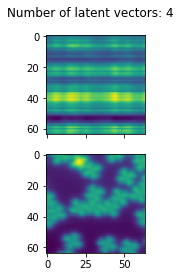

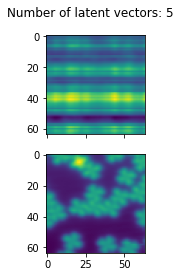

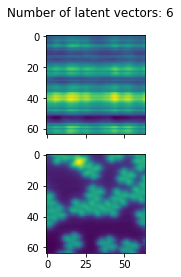

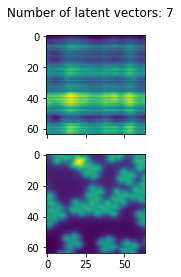

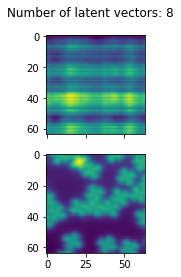

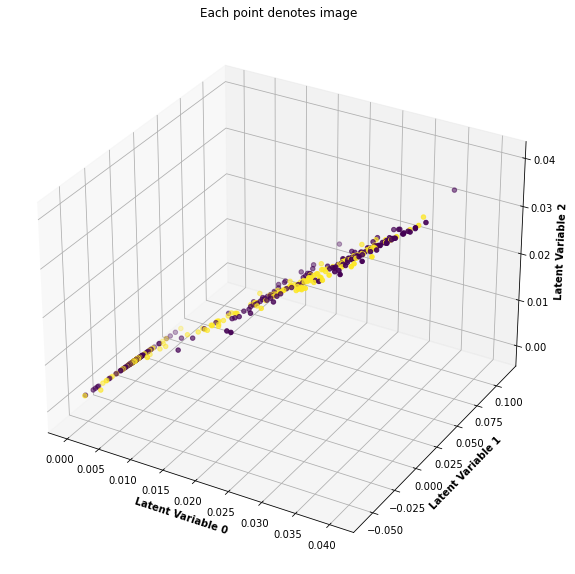

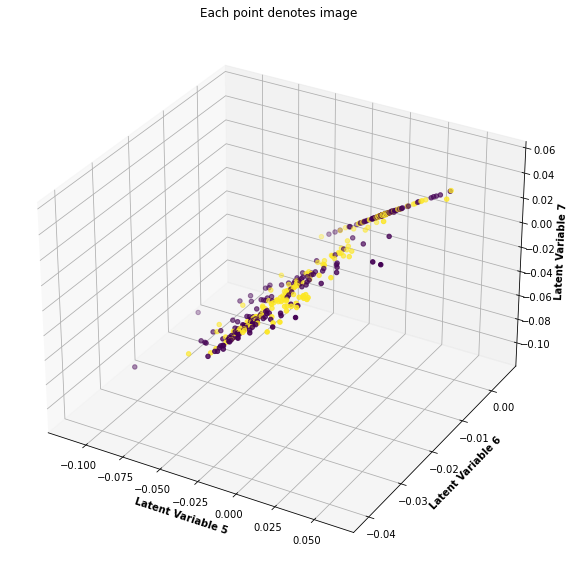

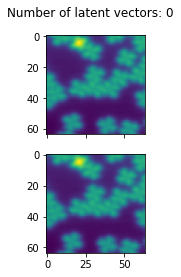

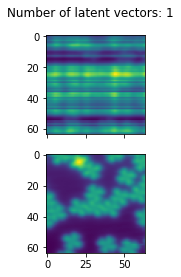

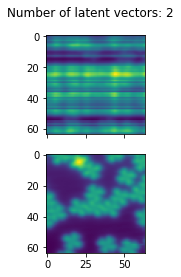

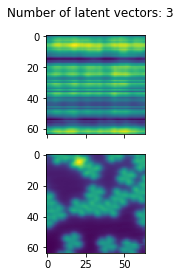

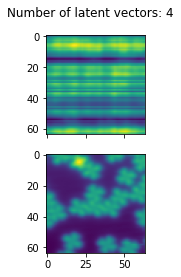

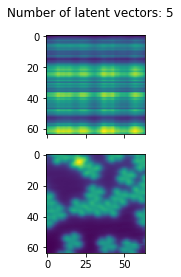

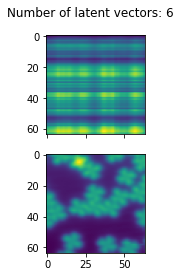

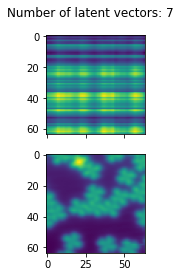

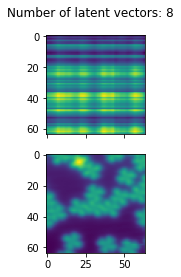

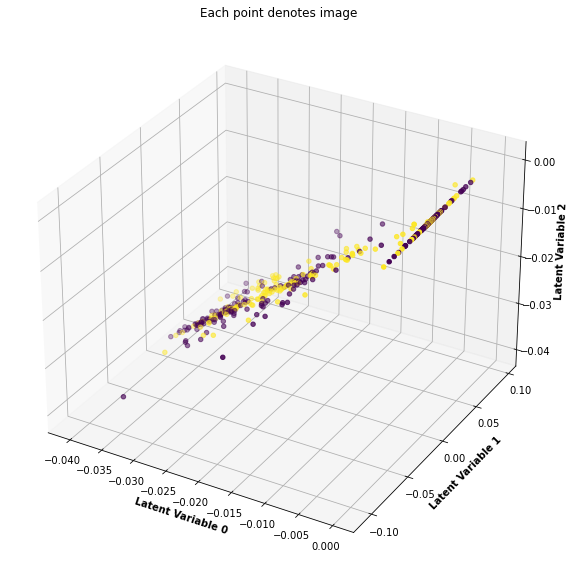

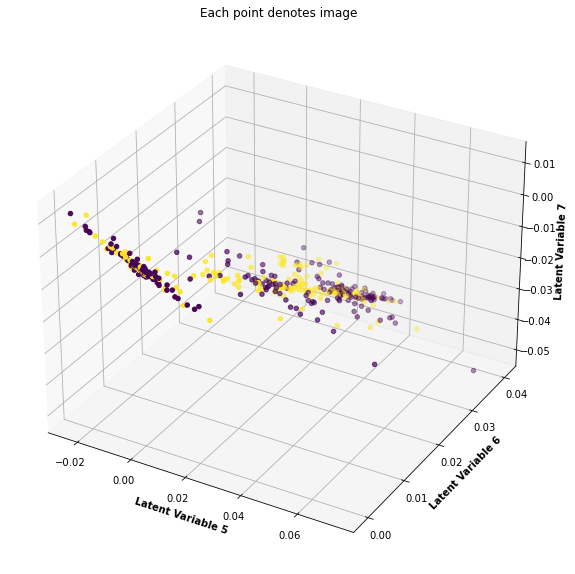

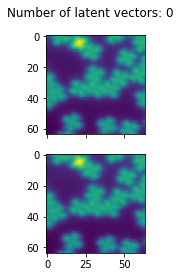

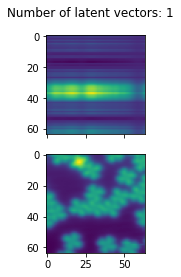

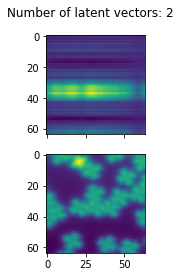

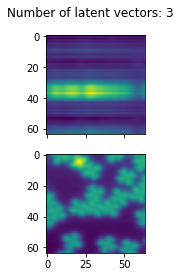

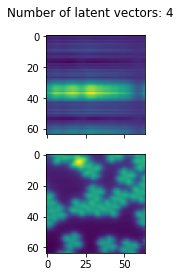

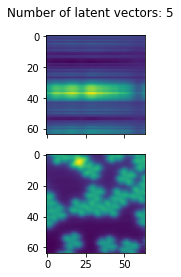

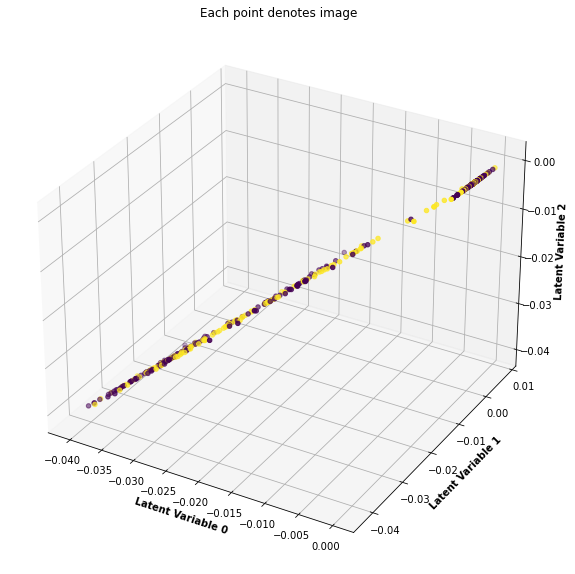

IndexError: index 6 is out of bounds for dimension 1 with size 6

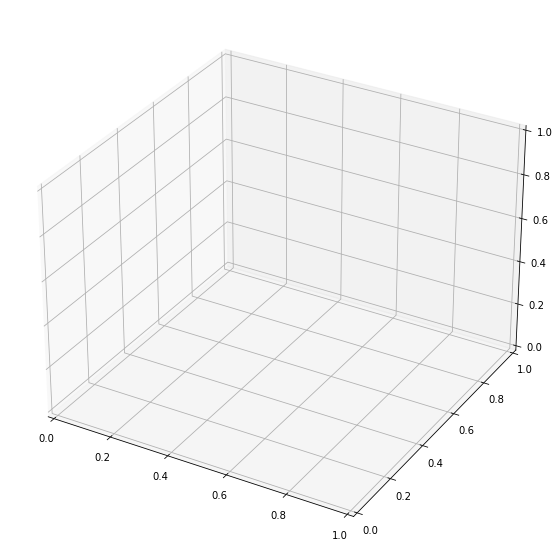

3:2: E225 missing whitespace around operator
10:19: E231 missing whitespace after ','
10:27: E251 unexpected spaces around keyword / parameter equals
10:29: E251 unexpected spaces around keyword / parameter equals
27:1: W293 blank line contains whitespace
28:9: E117 over-indented
28:9: E303 too many blank lines (2)
35:80: E501 line too long (81 > 79 characters)
51:80: E501 line too long (80 > 79 characters)
93:1: W391 blank line at end of file


In [335]:


X= data_X
Y = data_y
n_folds = 3
R_max = 9
lambda_max = 6
la = 9

cv = KFold(n_folds,shuffle = True)
fold = 0
PLS_r = []
PLS_q2 = []
HOPLS_l = []
HOPLS_r = []
HOPLS_q2 = []
NPLS_r = []
HOPLS_train_q2 = []
PLS_train_q2 = []
NPLS_train_q2 = []
NPLS_q2 = []
PLS_hyper = np.zeros((n_folds, R_max))
HOPLS_hyper = np.zeros((n_folds, lambda_max - 1, R_max))
NPLS_hyper = np.zeros((n_folds, R_max))
for train_idx, valid_idx in cv.split(X, Y):

        
        X_train = torch.Tensor(X[train_idx])
        Y_train = torch.Tensor(np.array(Y)[train_idx.astype(int)])
        X_valid = torch.Tensor(X[valid_idx])
        Y_valid = torch.Tensor(np.array(Y)[valid_idx.astype(int)])
#         print (Y_train.shape)
        results = []
        for R in range(1, R_max + 1):
            results.append(compute_q2_pls(X_train, Y_train, X_valid, Y_valid, R))
        old_Q2 = -np.inf
        PLS_hyper[fold] = results
        for i in range(len(results)):
            Q2 = results[i]
            if Q2 > old_Q2:
                best_r = i + 1
                old_Q2 = Q2
        PLS_q2s = compute_q2_pls(X_train, Y_train, X_train, Y_train, best_r)
        PLS_train_q2.append(PLS_q2s)
        PLS_r.append(best_r)
        PLS_q2.append(old_Q2)

        results = []
        for lam in range(1, lambda_max):
            results.append(
                compute_q2_hopls(X_train, Y_train, X_valid, Y_valid, lam, R_max)
            )
        old_Q2 = -np.inf
        NPLS_hyper[fold] = results[0][1]
        for i in range(1, len(results)):
            r, Q2s = results[i]
            HOPLS_hyper[fold, i - 1] = Q2s
            Q2 = Q2s[r - 1]
            if Q2 > old_Q2:
                best_lam = i + 1
                best_r = r
                old_Q2 = Q2
        _, HOPLS_q2s = compute_q2_hopls(
            X_train, Y_train, X_train, Y_train, best_lam, best_r
        )
        _, NPLS_q2s = compute_q2_hopls(
            X_train, Y_train, X_train, Y_train, best_lam, best_r
        )
        HOPLS_train_q2.append(HOPLS_q2s[-1])
        NPLS_train_q2.append(NPLS_q2s[-1])
        HOPLS_l.append(best_lam)
        HOPLS_r.append(best_r)
        HOPLS_q2.append(old_Q2)
        best_npls_r = results[0][0]
        NPLS_r.append(best_npls_r)
        NPLS_q2.append(results[0][1][best_npls_r - 1])
        fold += 1
results = {
        "PLS_R": PLS_r,
        "PLS_Q2": PLS_q2,
        "PLS_train": PLS_train_q2,
        "PLS_hyp": PLS_hyper,
        "HOPLS_R": HOPLS_r,
        "HOPLS_L": HOPLS_l,
        "HOPLS_Q2": HOPLS_q2,
        "HOPLS_train": HOPLS_train_q2,
        "HOPLS_hyp": HOPLS_hyper,
        "NPLS_R": NPLS_r,
        "NPLS_Q2": NPLS_q2,
        "NPLS_train": NPLS_train_q2,
        "NPLS_hyp": NPLS_hyper,
    }


In [ ]:
results